<a href="https://colab.research.google.com/github/lukavujeva/ast425/blob/main/Marchal_et_al_2022b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mapping a lower limit on the mass fraction of the cold neutral medium using Fourier transformed HI 21cm emission line spectra



In [2]:
!pip install ROHSApy
!pip install marchalib -U
!pip install fBms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 14.1 MB/s eta 0:00:00


In [3]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_UMAEAST_Tb.fits
# !wget https://github.com/lukavujeva/ast425/blob/main/GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits

--2023-07-18 17:28:16--  https://github.com/lukavujeva/ast425/blob/main/GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4892 (4.8K) [text/plain]
Saving to: ‘GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits’

GHIGLS_NCPL_Tb_CNM_ 100%[===================>]   4.78K  --.-KB/s    in 0s      

2023-07-18 17:28:16 (89.9 MB/s) - ‘GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits’ saved [4892/4892]



In [59]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.fft import rfftn

from ROHSApy import ROHSA
import marchalib as ml

name = "CNM"
fitsname = "GHIGLS_NCPL_Tb_"+name+"_IVC_n6_final.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
data = hdu[0].data
core = ROHSA(data, hdr)

In [60]:
#Get sub velocity range
v = core.v
dv = np.abs(hdr["CDELT3"]*1.e-3)
vmin = -20
vmax = 20
# idvmax = np.where((v > vmin) & (v < vmax))[0][::-1][0]
# idvmin = np.where((v > vmin) & (v < vmax))[0][0]
#
# subv = v[idvmin:idvmax]
cube = data

NHI = np.sum(data,0) * dv * 1.82243e+18 / 1.e19

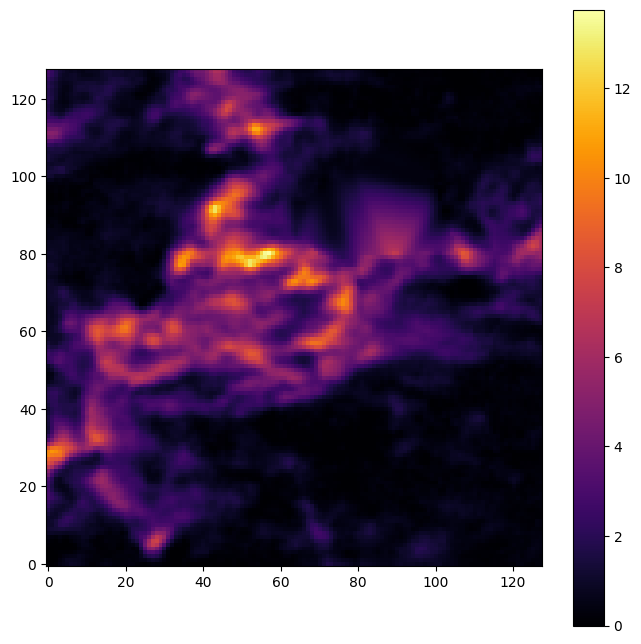

In [61]:
#Plot total column density map
plt.figure(figsize=(8,8))
plt.imshow(NHI, origin="lower", cmap="inferno")
plt.colorbar()

In [62]:
#Fourier all cube along v axis
hfreqs = np.fft.rfftfreq(cube.shape[0], dv)

hsfft = np.zeros((len(hfreqs),cube.shape[1],cube.shape[2]))
for i in tqdm(np.arange(cube.shape[1])):
    for j in np.arange(cube.shape[2]):
        s = cube[:,i,j]
        #Apodization
        tapper = ml.apodize_1d(0.9,len(s))
        s_apod = s * tapper
        hsfft[:,i,j] = np.abs(rfftn(s_apod))
        #Normalization by total NHI (FFT at k=0)
        hsfft[:,i,j] /= hsfft[0,i,j]

#Selected kv cut (see paper)
kcut = 0.12

 13%|█▎        | 17/128 [00:00<00:00, 168.29it/s]

<ipython-input-62-b46a11bffcdd>:13: RuntimeWarning: invalid value encountered in true_divide
  hsfft[:,i,j] /= hsfft[0,i,j]



100%|██████████| 128/128 [00:00<00:00, 177.41it/s]


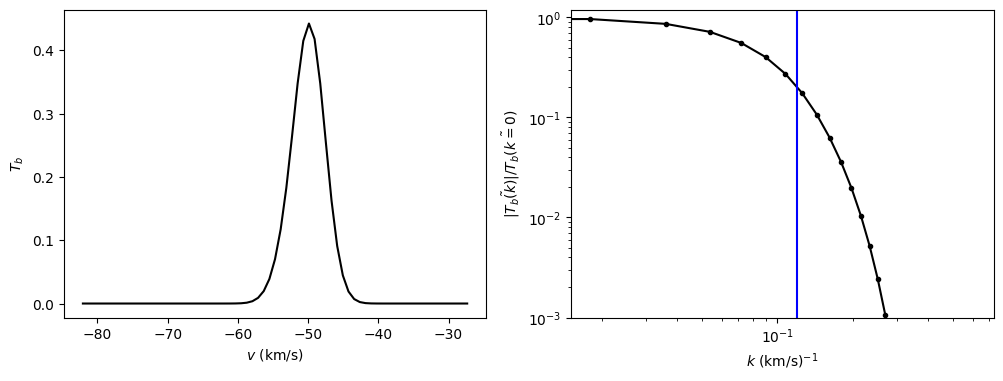

In [63]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
x = 40; y = 65
ax1.plot(v, cube[:,x,y], "-k")
ax1.set_ylabel(r"$T_b$")
ax1.set_xlabel(r"$v$ (km/s)")
ax2.plot(hfreqs, hsfft[:,x,y], ".-k")
ax2.plot([kcut, kcut], [0,2], "-b")
ax2.set_ylim([1.e-3,1.2])
ax2.set_ylabel(r"|$\tilde{T_b(k)}$|/$\tilde{T_b(k=0)}$")
ax2.set_xlabel(r"$k$ (km/s)$^{-1}$")
ax2.set_xscale("log")
ax2.set_yscale("log")

In [64]:
klim = np.where(np.sort(hfreqs) > kcut)[0][0]
print(klim, hfreqs[klim])
fcnm_low = np.max(hsfft[klim:],0)

7 0.1256763394186369


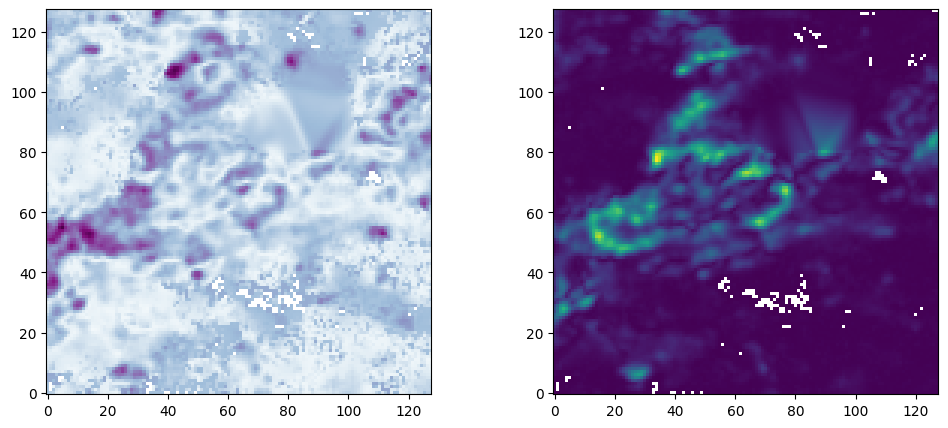

In [65]:
#Plot mass fraction map
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.imshow(fcnm_low, origin="lower", vmin=0.,
          cmap="BuPu")
ax2.imshow(fcnm_low*NHI, origin="lower", vmin=0.,
          cmap="viridis")

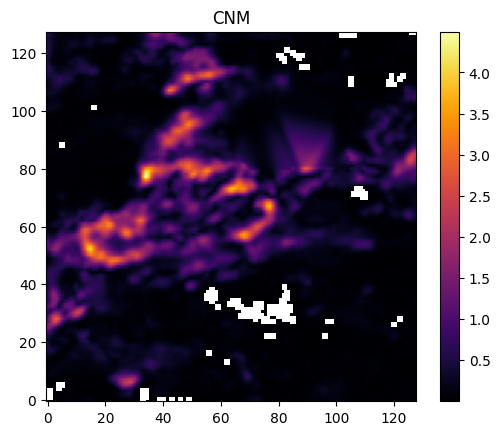

In [66]:
plt.imshow(fcnm_low*NHI, origin="lower",
          cmap="inferno")
plt.title(str(name))
plt.colorbar()